# Добавление имен клиентов в базу данных
В первом релизе мы построили базовую модель, которая по небольшому набору признаков строит прогноз относительно дефолта клиента. Как уже было рассмотрено в `research_version_1.ipynb`, мы достигли не очень внушительных метрик качества - лишь около 60% accuracy и AUROC.

Для того, чтобы улучшить точность нашей модели, нам было бы неплохо воспользоваться и оставшимися (13) признаками. Однако мы не будем запрашивать их у клиента напрямую. Мы представим, что данные признаки хранятся где-то в базе данных банка. И, например, вводя свои имя и фамилию, клиент будет предоставлять банку свои паспортные данные, по которым банк получит доступ к информации о клиенте из базы данных.

Для того, чтобы провернуть данную схему, необходимо насытить наши данные именами и фамилиями наших клиентов. В базе данных мы будем хранить данные из исходной таблицы, помеченные флагом `test` - так мы сможем заставить модель работать только с теми данными, которые она не видела при обучении.

Итак, приступим.

Содержание:
1. Импорт библиотек
2. Загрузка данных
3. Предобработка данных
    - Общие моменты
    - Тренировочная выборка
    - Тестовая выборка
4. Генерация имен

## 1. Импорт библиотек

In [1]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

## 2. Загрузка данных

In [2]:
application_info = pd.read_csv("../data/raw/application_info.csv", index_col="id")
application_info.head()

,application_dt,sample_cd,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg
id,,,,,,,,,,,,,,,,,,
1,01JAN2014,train,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N
2,01JAN2014,train,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N
3,01JAN2014,train,SCH,M,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N
4,01JAN2014,train,GRD,F,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N
5,01JAN2014,train,UGR,F,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N


In [3]:
application_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205296 entries, 1 to 205296
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   application_dt   205296 non-null  object 
 1   sample_cd        205296 non-null  object 
 2   education_cd     204384 non-null  object 
 3   gender_cd        205296 non-null  object 
 4   age              205296 non-null  int64  
 5   car_own_flg      205296 non-null  object 
 6   car_type_flg     205296 non-null  object 
 7   appl_rej_cnt     205296 non-null  int64  
 8   good_work_flg    205296 non-null  int64  
 9   Score_bki        205296 non-null  float64
 10  out_request_cnt  205296 non-null  int64  
 11  region_rating    205296 non-null  int64  
 12  home_address_cd  205296 non-null  int64  
 13  work_address_cd  205296 non-null  int64  
 14  income           205296 non-null  int64  
 15  SNA              205296 non-null  int64  
 16  first_time_cd    205296 non-null  int64  
 

In [4]:
default_info = pd.read_csv("../data/raw/default_flg.csv", index_col="id")
default_info.head()

,default_flg
id,
1,0
2,0
3,0
4,0
5,0


## 3. Предобработка данных
### Общие моменты
Первым делом удалим столбец `application_dt` - он нам не пригодится

In [5]:
application_info = application_info.drop(["application_dt"], axis=1)
application_info.head()

,sample_cd,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg
id,,,,,,,,,,,,,,,,,
1,train,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N
2,train,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N
3,train,SCH,M,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N
4,train,GRD,F,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N
5,train,UGR,F,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N


Заменим все категориальные значения `Y`, `N`, а также категории образования на соответствующие значения (см. `research_version_1.ipynb`)

In [6]:
# Данные отсутствуют только в колонке с образованием
application_info["education_cd"] = application_info["education_cd"].fillna("None")

application_info = application_info.replace({
    "Y": 1,    # Да/В наличии
    "N": 0,    # Нет/Отсутствует
    "None": 0, # Нет образования
    "SCH": 1,  # Школьное образование, среднее или базовое
    "GRD": 2,  # Выпускник, оконченное среднее, среднее-специальное или профессиональное
    "UGR": 3,  # Студент или уровень бакалавриата, неоконченое высшее
    "PGR": 4,  # Магистратура, аспирантура, уровень выше бакалавриата
    "ACD": 5,  # Ученая степень
})

# Значения пола ("М" и "F") менять не будем. Мы их все равно по итогу удалим
# Но пока мы их оставим, чтобы назначить соответствующим полам соответствующие имена

application_info.head()

C:\Users\Михаил\AppData\Local\Temp\ipykernel_7304\3771718267.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  application_info = application_info.replace({


,sample_cd,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg
id,,,,,,,,,,,,,,,,,
1,train,1,M,27,1,1,0,0,-1.917831,0,40,2,3,32000,1,4,0
2,train,2,F,26,0,0,0,0,-1.153144,2,60,2,3,50000,2,1,0
3,train,1,M,35,0,0,0,1,-1.732810,0,40,1,2,20000,4,3,0
4,train,2,F,35,0,0,0,1,-2.552133,2,20,2,3,80000,1,3,0
5,train,3,F,24,0,0,0,0,-1.914581,1,50,2,3,27000,1,2,0


Переименуем столбцы, для большей ясности. 

Напоминалка по смыслу признаков:
- `id` - Анонимизированный идентификатор заявителя
- `application_dt` - Дата подачи заявки
- `sample_cd` - Категория выборки
- `education_cd` - Образование
- `gender_cd` - Пол
- `age` - Возраст
- `car_own_flg` - Флаг наличия автомобиля
- `car_type_flg` - Флаг наличия иномарки
- `appl_rej_cnt` - Количество отказанных прошлых заявок
- `good_work_flg` - Флаг наличия "хорошей" работы
- `Score_bki` - Скор балл по данным из бюро кредитных историй
- `out_request_cnt` - Количество запросов в бюро
- `region_rating` - Рейтинг региона
- `home_address_cd` - Категоризатор домашнего адреса
- `work_address_cd` - Категоризатор рабочего адреса
- `income` - Доход заявителя
- `SNA` - Связь заявителя с клиентами
- `first_time_cd` - Давность наличия информации о заявителе
- `Air_flg` - Наличие загран паспорта

In [7]:
application_info = application_info.rename(columns={
    "sample_cd": "sample_type",
    "education_cd": "education",
    "gender_cd": "gender",
    "car_own_flg": "has_car",
    "car_type_flg": "car_is_foreign",
    "appl_rej_cnt": "rejected_applications_count",
    "good_work_flg": "has_work",
    "Score_bki": "bki_score",
    "out_request_cnt": "requests_count",
    "home_address_cd": "home_address_category",
    "work_address_cd": "work_address_category",
    "SNA": "social_network_analysis_score",
    "first_time_cd": "first_record_age",
    "Air_flg": "has_passport"
})

application_info.columns

Index(['sample_type', 'education', 'gender', 'age', 'has_car',
       'car_is_foreign', 'rejected_applications_count', 'has_work',
       'bki_score', 'requests_count', 'region_rating', 'home_address_category',
       'work_address_category', 'income', 'social_network_analysis_score',
       'first_record_age', 'has_passport'],
      dtype='object')

Впредь наши признаки будут представлены следующими названиями:
- `id` - Анонимизированный идентификатор заявителя
- `sample_type` - Категория выборки
- `education` - Образование
- `gender` - Пол
- `age` - Возраст
- `has_car` - Флаг наличия автомобиля
- `car_is_foreign` - Флаг наличия иномарки
- `rejected_applications_count` - Количество отказанных прошлых заявок
- `has_work` - Флаг наличия "хорошей" работы
- `bki_score` - Скор балл по данным из бюро кредитных историй
- `requests_cnt` - Количество запросов в бюро
- `region_rating` - Рейтинг региона
- `home_address_category` - Категоризатор домашнего адреса
- `work_address_category` - Категоризатор рабочего адреса
- `income` - Доход заявителя
- `social_network_analysis_score` - Связь заявителя с клиентами
- `first_record_age` - Давность наличия информации о заявителе
- `has_passport` - Наличие загран паспорта

In [8]:
application_info.head()

,sample_type,education,gender,age,has_car,car_is_foreign,rejected_applications_count,has_work,bki_score,requests_count,region_rating,home_address_category,work_address_category,income,social_network_analysis_score,first_record_age,has_passport
id,,,,,,,,,,,,,,,,,
1,train,1,M,27,1,1,0,0,-1.917831,0,40,2,3,32000,1,4,0
2,train,2,F,26,0,0,0,0,-1.153144,2,60,2,3,50000,2,1,0
3,train,1,M,35,0,0,0,1,-1.732810,0,40,1,2,20000,4,3,0
4,train,2,F,35,0,0,0,1,-2.552133,2,20,2,3,80000,1,3,0
5,train,3,F,24,0,0,0,0,-1.914581,1,50,2,3,27000,1,2,0


In [9]:
print(application_info.columns, f"\nЧисло признаков: {application_info.shape[1]}")

Index(['sample_type', 'education', 'gender', 'age', 'has_car',
       'car_is_foreign', 'rejected_applications_count', 'has_work',
       'bki_score', 'requests_count', 'region_rating', 'home_address_category',
       'work_address_category', 'income', 'social_network_analysis_score',
       'first_record_age', 'has_passport'],
      dtype='object') 
Число признаков: 17


Изменим порядок признаков для дальнейшего удобства

In [10]:
application_info = application_info[[
    'sample_type',
    'gender',
    'age',
    'education',
    'income',
    'has_car',
    'car_is_foreign',
    'has_work',
    'has_passport',
    'bki_score',
    'requests_count',
    'rejected_applications_count',
    'region_rating', 
    'home_address_category',
    'work_address_category',
    'social_network_analysis_score',
    'first_record_age',
]]

application_info.head()

,sample_type,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age
id,,,,,,,,,,,,,,,,,
1,train,M,27,1,32000,1,1,0,0,-1.917831,0,0,40,2,3,1,4
2,train,F,26,2,50000,0,0,0,0,-1.153144,2,0,60,2,3,2,1
3,train,M,35,1,20000,0,0,1,0,-1.732810,0,0,40,1,2,4,3
4,train,F,35,2,80000,0,0,1,0,-2.552133,2,0,20,2,3,1,3
5,train,F,24,3,27000,0,0,0,0,-1.914581,1,0,50,2,3,1,2


Замечательно, наиболее простые признаки в начале. Теперь разделим нашу выборку на тренировочную и тестовую

In [11]:
train_data = application_info[application_info.sample_type != "test"]
test_data = application_info[application_info.sample_type == "test"]

application_info.shape, train_data.shape, test_data.shape

((205296, 17), (180816, 17), (24480, 17))

### Тренировочная выборка
Присоединим метки дефолта к тренировочным данным.

In [12]:
train_data = pd.merge(
    left=train_data,
    right=default_info,
    how="inner",
    on="id"
)

train_data.shape

(180816, 18)

In [13]:
train_data = train_data.rename(columns={"default_flg": "default"})
train_data.head()

,sample_type,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,default
id,,,,,,,,,,,,,,,,,,
1,train,M,27,1,32000,1,1,0,0,-1.917831,0,0,40,2,3,1,4,0
2,train,F,26,2,50000,0,0,0,0,-1.153144,2,0,60,2,3,2,1,0
3,train,M,35,1,20000,0,0,1,0,-1.732810,0,0,40,1,2,4,3,0
4,train,F,35,2,80000,0,0,1,0,-2.552133,2,0,20,2,3,1,3,0
5,train,F,24,3,27000,0,0,0,0,-1.914581,1,0,50,2,3,1,2,0


Для данного датасета, который в дальнейшем мы будем использовать как тренировочный, нам не пригодятся такие столбцы как `sample_type` и `gender`. Делить датасет мы будем самостоятельно, а отсутствие пола избавит от дискриминации предсказания.

In [14]:
train_data = train_data.drop(["sample_type", "gender"], axis=1)
train_data.head()

,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,default
id,,,,,,,,,,,,,,,,
1,27,1,32000,1,1,0,0,-1.917831,0,0,40,2,3,1,4,0
2,26,2,50000,0,0,0,0,-1.153144,2,0,60,2,3,2,1,0
3,35,1,20000,0,0,1,0,-1.732810,0,0,40,1,2,4,3,0
4,35,2,80000,0,0,1,0,-2.552133,2,0,20,2,3,1,3,0
5,24,3,27000,0,0,0,0,-1.914581,1,0,50,2,3,1,2,0


Отлично! Мы выделили самый полный тренировочный датасет, который мы можем себе позволить из исходных данных. Далее мы будем обучать нашу модель на этом датасете. А пока сохраним его.

In [15]:
train_data.to_csv("../data/processed/train_dataset.csv", index=True)

### Тестовая выборка


In [16]:
test_data.head()

,sample_type,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age
id,,,,,,,,,,,,,,,,,
180817,test,F,46,1,18000,0,0,0,0,-2.421881,3,0,60,1,3,2,2
180818,test,M,41,1,500000,1,1,0,0,-1.144732,2,0,60,1,2,1,4
180819,test,F,28,2,30000,1,0,0,0,-2.000133,2,1,60,1,2,2,3
180820,test,F,35,3,40000,1,0,0,0,-2.523739,0,0,50,2,3,4,1
180821,test,M,32,1,30000,0,0,0,1,-1.754231,1,0,80,1,1,1,4


Удалим столбец `sample_type`. Он нам больше не пригодится

In [17]:
test_data = test_data.drop(["sample_type"], axis=1)
test_data.head()

,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age
id,,,,,,,,,,,,,,,,
180817,F,46,1,18000,0,0,0,0,-2.421881,3,0,60,1,3,2,2
180818,M,41,1,500000,1,1,0,0,-1.144732,2,0,60,1,2,1,4
180819,F,28,2,30000,1,0,0,0,-2.000133,2,1,60,1,2,2,3
180820,F,35,3,40000,1,0,0,0,-2.523739,0,0,50,2,3,4,1
180821,M,32,1,30000,0,0,0,1,-1.754231,1,0,80,1,1,1,4


Посмотрим, как распределен параметр пола в тестовой выборке

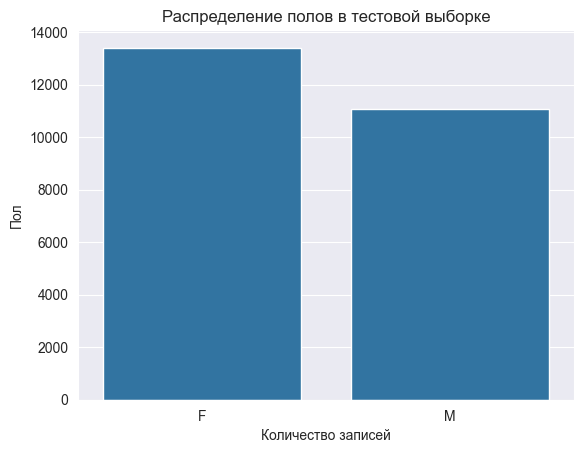

In [18]:
sns.barplot(test_data["gender"].value_counts())
plt.title("Распределение полов в тестовой выборке")
plt.xlabel("Количество записей")
plt.ylabel("Пол")
plt.show()

Женщин чуть больше мужчин. Это не страшно, дисбаланса классов нет, т.к. мы не будем использовать этот признак для обучения или тестирования. Просто согласно этому признаку мы назначим имена и фамилии разным записям.

Сохраним распределение в виде таблицы

In [19]:
gender_distribution = test_data["gender"].value_counts().to_frame().T
gender_distribution

gender,F,M
count,13410,11070


Разберемся наконец с именами

## 4. Генерация имен
Итак, мы имеем следующее распределение полов

In [20]:
gender_distribution

gender,F,M
count,13410,11070


Если делать списки имен и фамилий и пробовать все их комбинации, то мы можем посчитать необходимое число имен и фамилий, которые нам необходимо завести, просто взяв квадратный корен из размеров полов

In [21]:
import math

female_required_count = gender_distribution["F"].iloc[0].item()
male_required_count = gender_distribution["M"].iloc[0].item()

print(f"Количество имен и фамилий для девушек: {math.ceil(math.sqrt(female_required_count))}")
print(f"Количество имен и фамилий для мужчин: {math.ceil(math.sqrt(male_required_count))}")

Количество имен и фамилий для девушек: 116
Количество имен и фамилий для мужчин: 106


Т.е. нам необходимо по сто с копейками имен и фамилий для мужчин и девушек, чтобы назначить их всей тестовой выборке. Собирать это все сам я конечно же не буду, а позволю за меня это сделать гптшке =)))

In [22]:
male_names = set([
    "Александр", "Алексей", "Анатолий", "Андрей", "Антон", "Аркадий", "Арсений", "Артём", "Богдан",
    "Борис", "Вадим", "Валентин", "Валерий", "Василий", "Виктор", "Виталий", "Владимир", "Владислав",
    "Вячеслав", "Геннадий", "Георгий", "Григорий", "Даниил", "Денис", "Дмитрий", "Евгений", "Егор",
    "Иван", "Игнат", "Игорь", "Илья", "Кирилл", "Константин", "Лев", "Леонид", "Максим", "Марат",
    "Матвей", "Михаил", "Никита", "Николай", "Олег", "Павел", "Пётр", "Роман", "Руслан", "Савелий",
    "Сергей", "Станислав", "Степан", "Тимофей", "Тимур", "Фёдор", "Юрий", "Ярослав", "Альберт",
    "Али", "Альфред", "Всеволод", "Викентий", "Виссарион", "Гавриил", "Глеб", "Давид", "Елисей",
    "Захар", "Зиновий", "Клим", "Кузьма", "Лазарь", "Лука", "Мирон", "Назар", "Наум", "Осип",
    "Платон", "Прохор", "Родион", "Семён", "Спартак", "Тарас", "Трофим", "Филипп", "Харитон",
    "Эдуард", "Эльдар", "Эмиль", "Эрик", "Юлиан", "Яков", "Ян", "Ярополк", "Артур", "Вениамин",
    "Герман", "Данила", "Ефим", "Капитон", "Митрофан", "Никон", "Марсель"
])

male_names_count = len(male_names)
male_names_count

101

In [23]:
male_surnames = set([
    "Иванов", "Петров", "Сидоров", "Кузнецов", "Смирнов", "Попов", "Васильев", "Новиков", "Фёдоров", "Морозов",
    "Волков", "Алексеев", "Лебедев", "Семенов", "Егоров", "Николаев", "Зайцев", "Соловьёв", "Михайлов", "Макаров",
    "Андреев", "Козлов", "Степанов", "Орлов", "Артемьев", "Гаврилов", "Титов", "Крылов", "Карпов", "Григорьев",
    "Фролов", "Сергеев", "Павлов", "Мельников", "Калинин", "Куликов", "Назаров", "Шестаков", "Данилов", "Жуков",
    "Баранов", "Комаров", "Суворов", "Воробьёв", "Фомин", "Чернов", "Абрамов", "Мартынов", "Ефимов", "Голубев",
    "Кириллов", "Миронов", "Максимов", "Климов", "Куликов", "Сафонов", "Логинов", "Сорокин", "Виноградов", "Федотов",
    "Ушаков", "Дмитриев", "Белов", "Тарасов", "Белозёров", "Герасимов", "Емельянов", "Никифоров", "Матвеев", "Горбунов",
    "Анисимов", "Панов", "Ларионов", "Сазонов", "Селезнёв", "Панфилов", "Кондратьев", "Силин", "Мухин", "Капустин",
    "Прохоров", "Рогов", "Тимофеев", "Осипов", "Дроздов", "Филатов", "Рябов", "Поляков", "Третьяков", "Гусев",
    "Кочетов", "Сычёв", "Быков", "Кузьмин", "Костин", "Шубин", "Игнатов", "Филонов", "Кудрявцев", "Зиновьев",
    "Мясников", "Старостин", "Кочергин", "Грачёв", "Стариков", "Князев", "Суханов", "Соловьёв", "Шаповалов", "Козин",
    "Гордеев", "Савельев", "Романов", "Копылов", "Горелов", "Симонов", "Михеев", "Круглов", "Снегирёв", "Шаров", 
    "Костянок", "Асташёнок"
])

male_surnames_count = len(male_surnames)
male_surnames_count 

120

In [24]:
print(f"Требуется мужских комбинаций: {male_required_count}, можeм сделать {male_names_count * male_surnames_count}")

Требуется мужских комбинаций: 11070, можeм сделать 12120


С мужчинами разобрались. Переходим к девушкам.

In [25]:
female_names = set([
    "Анна", "Мария", "Елена", "Ольга", "Наталья", "Татьяна", "Ирина", "Светлана", "Людмила", "Галина",
    "Валентина", "Вера", "Надежда", "Любовь", "Ксения", "Анастасия", "Екатерина", "Юлия", "Полина", "Дарья",
    "Алёна", "Виктория", "Алина", "Карина", "Елизавета", "София", "Зоя", "Нина", "Раиса", "Лариса",
    "Инна", "Алла", "Майя", "Вероника", "Серафима", "Агата", "Агнесса", "Аделина", "Александра", "Альбина",
    "Ангелина", "Анфиса", "Василиса", "Варвара", "Владислава", "Гертруда", "Диана", "Доминика", "Жанна", "Зинаида",
    "Злата", "Зоя", "Илона", "Ия", "Кира", "Клавдия", "Кристина", "Лидия", "Лилия", "Любомира",
    "Марианна", "Маргарита", "Марина", "Марта", "Мелания", "Милана", "Мирослава", "Наталия", "Нелли", "Ника",
    "Оксана", "Пелагея", "Регина", "Римма", "Роза", "Руслана", "Сабина", "Снежана", "Софья", "Таисия",
    "Тамара", "Теона", "Ульяна", "Фаина", "Флора", "Эвелина", "Эльвира", "Эмма", "Эмилия", "Юлиана",
    "Яна", "Ярослава", "Аврора", "Аида", "Алиса", "Амелия", "Белла", "Валерия", "Виолетта", "Гузель",
    "Евдокия", "Евгения", "Жасмин", "Зарина", "Зояна", "Инесса", "Иринада", "Капитолина", "Ксенияра", "Любава",
    "Милена", "Наташа", "Олеся", "Патриция", "Рада", "Сильвия", "Софина", "Тина", "Фаустина", "Элеонора"
])

female_names_count = len(female_names)
female_names_count

119

In [26]:
female_surnames = set([
    "Иванова", "Петрова", "Сидорова", "Кузнецова", "Смирнова", "Попова", "Васильева", "Новикова", "Фёдорова", "Морозова",
    "Волкова", "Алексеева", "Лебедева", "Семенова", "Егорова", "Николаева", "Зайцева", "Соловьёва", "Михайлова", "Макарова",
    "Андреева", "Козлова", "Степанова", "Орлова", "Артемьева", "Гаврилова", "Титова", "Крылова", "Карпова", "Григорьева",
    "Фролова", "Сергеева", "Павлова", "Мельникова", "Калинина", "Куликова", "Назарова", "Шестакова", "Данилова", "Жукова",
    "Баранова", "Комарова", "Суворова", "Воробьёва", "Фомина", "Чернова", "Абрамова", "Мартынова", "Ефимова", "Голубева",
    "Кириллова", "Миронова", "Максимова", "Климова", "Сафонова", "Логинова", "Сорокина", "Виноградова", "Федотова", "Ушакова",
    "Дмитриева", "Белова", "Тарасова", "Белозёрова", "Герасимова", "Емельянова", "Никифорова", "Матвеева", "Горбунова", "Анисимова",
    "Панова", "Ларионова", "Сазонова", "Селезнёва", "Панфилова", "Кондратьева", "Силина", "Мухина", "Капустина", "Прохорова",
    "Рогова", "Тимофеева", "Осипова", "Дроздова", "Филатова", "Рябова", "Полякова", "Третьякова", "Гусева", "Кочетова",
    "Сычёва", "Быкова", "Кузьмина", "Костина", "Шубина", "Игнатова", "Филонова", "Кудрявцева", "Зиновьева", "Мясникова",
    "Старостина", "Кочергина", "Грачёва", "Старикова", "Князева", "Суханова", "Шаповалова", "Козина", "Гордеева", "Савельева",
    "Романова", "Копылова", "Горелова", "Симонова", "Михеева", "Круглова", "Снегирёва", "Шарова", "Воронова", "Ершова",
    "Литвинова", "Малышева", "Соловова", "Тихонова", "Федосеева", "Щербакова", "Яковлева", "Захарова", "Киреева", "Лапина"
])

female_surnames_count = len(female_surnames)
female_surnames_count

130

In [27]:
print(f"Требуется женских комбинаций: {female_required_count}, можeм сделать {female_names_count * female_surnames_count}")

Требуется женских комбинаций: 13410, можeм сделать 15470


Девушки тоже готовы. С GPT на сбор имен ушло 5 минут 👍

Теперь будем составлять комбинации. Нет нужды сохранять имя и фамилию отдельно, т.к. мы будем требовать и имя, и фамилию от пользователя. Сразу же будем перемешивать комбинации.

In [28]:
all_male_name_combinations = []
for name in male_names:
    for surname in male_surnames:
        all_male_name_combinations.append(f"{name} {surname}")

random.seed(42)
random.shuffle(all_male_name_combinations)

all_female_name_combinations = []
for name in female_names:
    for surname in female_surnames:
        all_female_name_combinations.append(f"{name} {surname}")       

random.seed(42)
random.shuffle(all_female_name_combinations)

print(f"Количество мужских комбинаций - {len(all_male_name_combinations)}") 
print(f"Количество женских комбинаций - {len(all_female_name_combinations)}") 

Количество мужских комбинаций - 12120
Количество женских комбинаций - 15470


Оставим столько имен, сколько необходимо, чтобы покрыть тестовую выборку

In [29]:
all_male_name_combinations = all_male_name_combinations[:male_required_count]
all_female_name_combinations = all_female_name_combinations[:female_required_count]

print(f"Количество мужских комбинаций - {len(all_male_name_combinations)}") 
print(f"Количество женских комбинаций - {len(all_female_name_combinations)}") 

Количество мужских комбинаций - 11070
Количество женских комбинаций - 13410


Сформируем общий набор имен и фамилий и сохраним его как датафрейм

In [30]:
all_name_combinations = [*all_female_name_combinations, *all_male_name_combinations]
all_name_combinations

['Амелия Фролова',
 'Злата Филатова',
 'Елена Петрова',
 'Алёна Сычёва',
 'Ксения Жукова',
 'Ника Новикова',
 'Инесса Козина',
 'Ия Белова',
 'Рада Грачёва',
 'Таисия Капустина',
 'Ксенияра Филатова',
 'Виктория Старостина',
 'Светлана Капустина',
 'Таисия Рябова',
 'Евдокия Снегирёва',
 'Роза Данилова',
 'Рада Титова',
 'Надежда Анисимова',
 'Валерия Егорова',
 'Гузель Лапина',
 'Эвелина Ершова',
 'Галина Тимофеева',
 'Владислава Кузнецова',
 'Олеся Матвеева',
 'Зояна Артемьева',
 'Ольга Попова',
 'Вера Козина',
 'Агнесса Крылова',
 'Эвелина Соловьёва',
 'Алиса Макарова',
 'Ангелина Фомина',
 'Эмма Николаева',
 'Агнесса Воробьёва',
 'Марта Иванова',
 'Сильвия Андреева',
 'Фаина Прохорова',
 'Зарина Куликова',
 'Ксения Горбунова',
 'Рада Сазонова',
 'Альбина Артемьева',
 'Евгения Панова',
 'Алёна Кудрявцева',
 'Юлия Зайцева',
 'Татьяна Комарова',
 'Лилия Филатова',
 'Марианна Панова',
 'Белла Козлова',
 'Теона Захарова',
 'Фаина Фролова',
 'Анна Николаева',
 'Виолетта Кудрявцева',
 'Па

Отсортируем тестовый датасет по полу

In [31]:
test_data = test_data.sort_values(by="gender")
test_data.head()

,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age
id,,,,,,,,,,,,,,,,
180817,F,46,1,18000,0,0,0,0,-2.421881,3,0,60,1,3,2,2
194752,F,43,2,25000,0,0,0,0,-1.919401,0,0,70,2,2,1,4
194753,F,55,2,70000,0,0,0,0,-2.113311,11,2,70,1,2,2,3
194754,F,40,3,100000,1,1,0,0,-1.556188,1,0,50,1,3,1,1
194755,F,27,4,30000,0,0,0,0,-1.851356,0,0,80,1,2,1,3


И присоединим к нему список имен

In [32]:
test_data["name_surname"] = all_name_combinations
test_data.head(10)

,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,name_surname
id,,,,,,,,,,,,,,,,,
180817,F,46,1,18000,0,0,0,0,-2.421881,3,0,60,1,3,2,2,Амелия Фролова
194752,F,43,2,25000,0,0,0,0,-1.919401,0,0,70,2,2,1,4,Злата Филатова
194753,F,55,2,70000,0,0,0,0,-2.113311,11,2,70,1,2,2,3,Елена Петрова
194754,F,40,3,100000,1,1,0,0,-1.556188,1,0,50,1,3,1,1,Алёна Сычёва
194755,F,27,4,30000,0,0,0,0,-1.851356,0,0,80,1,2,1,3,Ксения Жукова
194756,F,38,2,136000,0,0,0,0,-1.918505,1,0,80,1,1,1,4,Ника Новикова
194757,F,21,3,50000,0,0,0,0,-2.431599,0,3,80,1,2,4,3,Инесса Козина
194758,F,61,1,13000,0,0,0,1,-2.208843,0,0,70,1,3,1,4,Ия Белова
194759,F,35,1,12000,0,0,0,0,-2.340503,0,0,50,1,1,1,2,Рада Грачёва


In [33]:
test_data.tail(10)

,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,name_surname
id,,,,,,,,,,,,,,,,,
195783,M,44,1,90000,1,1,0,1,-1.318528,0,0,60,1,1,2,3,Платон Титов
186046,M,43,1,25000,1,1,0,0,-1.893710,2,0,60,1,2,1,2,Филипп Волков
186045,M,41,2,30000,1,0,0,0,-2.370162,0,0,50,1,3,1,4,Али Семенов
186044,M,34,1,7000,0,0,0,0,-2.433525,0,0,50,1,3,1,3,Альфред Козин
195787,M,32,2,500000,1,1,0,1,-1.855304,0,0,40,1,1,1,3,Прохор Лебедев
186043,M,29,2,120000,1,0,0,0,-1.348161,0,0,70,1,2,3,3,Владимир Попов
186041,M,43,2,47000,1,1,0,0,-1.777724,2,0,60,1,1,3,2,Андрей Миронов
186038,M,46,1,45000,0,0,0,0,-2.092247,2,4,50,1,2,4,3,Станислав Кочетов
195777,M,32,2,50000,1,1,0,0,-1.853842,0,1,40,1,2,2,3,Давид Морозов


In [34]:
test_data[test_data["name_surname"] == "Михаил Асташёнок"]

,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,name_surname
id,,,,,,,,,,,,,,,,,
201715,M,34,2,28000,0,0,0,0,-2.440641,1,0,60,1,2,2,4,Михаил Асташёнок


Допустим. Поменяем порядок колонок

In [35]:
test_data.shape

(24480, 17)

In [36]:
test_data = test_data[[
    "name_surname",
    *test_data.columns[:-1],
]]

test_data.shape

(24480, 17)

In [37]:
test_data.head()

,name_surname,gender,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age
id,,,,,,,,,,,,,,,,,
180817,Амелия Фролова,F,46,1,18000,0,0,0,0,-2.421881,3,0,60,1,3,2,2
194752,Злата Филатова,F,43,2,25000,0,0,0,0,-1.919401,0,0,70,2,2,1,4
194753,Елена Петрова,F,55,2,70000,0,0,0,0,-2.113311,11,2,70,1,2,2,3
194754,Алёна Сычёва,F,40,3,100000,1,1,0,0,-1.556188,1,0,50,1,3,1,1
194755,Ксения Жукова,F,27,4,30000,0,0,0,0,-1.851356,0,0,80,1,2,1,3


Сохраним тестовую выборку

In [38]:
test_data.to_csv("../data/processed/test_dataset.csv", index=True)